# Generate Full Disk images of GOES-R NetCDF files and upload them to GitLab database.

https://gitlab.com/adomakor412/goes-r_fd_image

In [1]:
import sys
from netCDF4 import Dataset
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.basemap import Basemap
from pathlib import Path
from subprocess import Popen
import itertools

from pyproj import Proj
import pyproj
import xarray as xr
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyresample import image, geometry
import sys
import metpy
import seaborn as sns
sns.set(style="darkgrid")
import pandas as pd
import statsmodels.api as sm
import os
import os.path as op
import glob
from convertdate import gregorian, ordinal

import warnings
#warnings.filterwarnings('ignore')

import logging
logger = logging.getLogger()

/home/radomako/.conda/envs/adomako/lib/python3.9/site-packages/pyresample/bilinear/__init__.py:50: UserWarning: XArray and/or zarr not found, XArrayBilinearResampler won't be available.
  warnings.warn("XArray and/or zarr not found, XArrayBilinearResampler won't be available.")


## Paths

In [2]:
storage = Path('../goes-r_fd_image/')
sharkfins_FD_NC = Path('~/scratch/gops/amqpfind/adomako_data/l1b_imagery_sharkfin/')
caterpillar_FD_NC = Path('~/scratch/gops/amqpfind/adomako_data/l1b_imagery_caterpillar_track/')

## Functions for unfiltered cloud mask

In [3]:
def Rad2BT(rad, planck_fk1, planck_fk2, planck_bc1, planck_bc2):
    """Radiances to Brightness Temprature (using black body equation)"""
    invRad = np.array(rad)**(-1)
    arg = (invRad*planck_fk1) + 1.0
    T = (- planck_bc1+(planck_fk2 * (np.log(arg)**(-1))) )*(1/planck_bc2) 
    return T

def createUnfilteredPlotArray(ncFile,npFile,npPath):#Filtered Histrogram for cloud clear sky mask
    Tmean= []
    times = []
    for ncf, npf in zip(ncFile, npFile):
        imageBox = np.load(op.join(npPath,npf))
        myFile = xr.open_dataset(op.join(ncPath,ncf))
        planck_fk1 = float(myFile['planck_fk1'].data)
        planck_fk2 = float(myFile['planck_fk2'].data) 
        planck_bc1 = float(myFile['planck_bc1'].data)                       
        planck_bc2 = float(myFile['planck_bc2'].data)     
        T = Rad2BT(imageBox.mean(), planck_fk1, planck_fk2, planck_bc1, planck_bc2)
        tString = ncf[31:38]
        times.append(tString)
        Tmean.append(T)
    return times, Tmean

def listurls(prefix,html):
    from bs4 import BeautifulSoup
    soup = BeautifulSoup(html.text)
    urllist = [elt['href'] for elt in soup.find_all(href=re.compile(prefix))]
    return urllist

def create_nc_Numpy(ncFile, pathOut):
    myFile = xr.open_dataset(ncFile,engine="netcdf4")
    dat = myFile.metpy.parse_cf('Rad')#myFile['Rad']
    geos = dat.metpy.cartopy_crs

    cartopy_extent_goes = geos.x_limits + geos.y_limits
    pyresample_extent_goes = (cartopy_extent_goes[0],
                                cartopy_extent_goes[2],
                                cartopy_extent_goes[1],
                                cartopy_extent_goes[3])
    goes_params = geos.proj4_params
    rad = dat.data
    
    def normIm(im,gamma=1.0,reverse=False):
        nim = ((im-np.nanmin(im))*(np.nanmax(im)-np.nanmin(im))**(-1))
        if reverse:#want clouds to be white
            nim = (1.0-nim**(gamma))
        return nim
    
    def goes_2_roi(geos_crs, 
               target_extent,
               target_rows,#actual length or base
               target_cols,#actual width or height
               cartopy_target_proj,
               data_key='Rad',
               radius_of_influence=50000):
        """Function that goes from loaded GOES data to data resampled in a projection for an extent"""
        cartopy_source_extent = geos_crs.x_limits + geos_crs.y_limits
        pyresample_source_extent = (cartopy_source_extent[0],
                                    cartopy_source_extent[2],
                                    cartopy_source_extent[1],
                                    cartopy_source_extent[3])
        rad = dat.data
        source_area = geometry.AreaDefinition('GOES-1X', 'Full Disk','GOES-1X', 
                                              geos_crs.proj4_params,
                                              rad.shape[1], rad.shape[0],
                                              pyresample_source_extent)
        area_target_def = geometry.AreaDefinition('areaTest', 'Target Region', 'areaTest',
                                            cartopy_target_proj.proj4_params,
                                            target_rows, target_cols,
                                            target_extent)
        #Read up on recommend class 
        #https://pyresample.readthedocs.io/en/latest/search.html?q=Numpy+Resampler+Bilinear&check_keywords
        
        #can suppress warning for long runs as to not generate an overload on the browser rendering .ipynb
        geos_con_nn = image.ImageContainerNearest(rad, 
                                                source_area, 
                                                radius_of_influence=radius_of_influence)

        # Here we are using pyresample for the remapping
        area_proj_con_nn = geos_con_nn.resample(area_target_def)
        return area_proj_con_nn.image_data
        
    def cartopy_pyresample_toggle_extent(input_extent):
        return np.array(input_extent)[np.array([0,2,1,3])]

    def transform_cartopy_extent(source_extent,source_proj, target_proj):
        target_extent = target_proj.transform_points(source_proj, 
                                                     np.array(source_extent[:2]),
                                                     np.array(source_extent[2:])).ravel()
        # target_extent in 3D, must be in 2D
        return cartopy_pyresample_toggle_extent(np.array(target_extent)[np.array([0,1,3,4])])
    pc = ccrs.PlateCarree()
    mc = ccrs.Mercator()

    # Convert extent from pc to mc (both cylindrical projections)
    extent_pc = [-109.59326, -102.40674, 8.94659, -8.94656]
    
    target_extent_mc_cartopy = transform_cartopy_extent(extent_pc, pc, mc)
    target_extent_mc_pyresample = cartopy_pyresample_toggle_extent(target_extent_mc_cartopy)
    
    roi_rads = goes_2_roi(geos,
               target_extent_mc_pyresample,
               401,1001,
               mc)
    ####
    full_filename = op.join(pathOut,ncFile[:-3])
    np.save(full_filename,roi_rads)
    myFile.close()
    return

def download(url,toPath, saveName):
    cmd = [ 'wget ' + url +' -P ' + toPath +' -O '+ saveName]#if re.search('C07',url)
    #print(cmd)
    pid = Popen(cmd, shell=True)
    pid.communicate()
    return

## Load data

In [4]:
Sat = [16,17]
band = range(7,17)
year = [2021]
month = list(range(1,3))
day = list(range(1,32))
hour = list(range(1,24))

In [5]:
search = list(itertools.product(Sat,\
        band,\
        year,\
        month,\
        day,\
        hour))

## Execution

/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C10_G16_s20210012000208_e20210012009528_c20210012009570.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C03_G16_s20210011440211_e20210011449519_c20210011449579.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C13_G16_s20210010640211_e20210010649530_c20210010649592.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C06_G16_s20210010950211_e20210010959525_c20210010959563.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C03_G16_s20210012130208_e20210012139516_c20210012139578.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C07_G16_s20210012140208_e20210012149528_c20210012149580.nc


<ipython-input-3-1ffd79499686>:5: RuntimeWarning: invalid value encountered in log
  T = (- planck_bc1+(planck_fk2 * (np.log(arg)**(-1))) )*(1/planck_bc2)


/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C15_G16_s20210011920209_e20210011929522_c20210011929589.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C14_G16_s20210011330211_e20210011339519_c20210011339595.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C15_G16_s20210011050211_e20210011059525_c20210011059597.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C11_G16_s20210010150209_e20210010159516_c20210010159570.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C08_G16_s20210011000211_e20210011009519_c20210011009585.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C05_G16_s20210012210208_e20210012219516_c20210012219572.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C12_G16_s20210010610211_e20210010619524_c20210010619586.nc
/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/Ra

<ipython-input-3-1ffd79499686>:5: RuntimeWarning: invalid value encountered in log
  T = (- planck_bc1+(planck_fk2 * (np.log(arg)**(-1))) )*(1/planck_bc2)


/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C07_G16_s20210011340211_e20210011349530_c20210011349584.nc


<ipython-input-3-1ffd79499686>:5: RuntimeWarning: invalid value encountered in log
  T = (- planck_bc1+(planck_fk2 * (np.log(arg)**(-1))) )*(1/planck_bc2)


/arcdata/goes/grb/goes16/2021/2021_01_01_001/abi/L1b/RadF/OR_ABI-L1b-RadF-M6C03_G16_s20210011840209_e20210011849517_c20210011849576.nc


KeyboardInterrupt: 

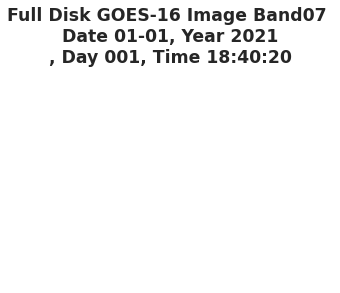

In [13]:
filelog = open('log_FD_image.txt','w')

for SS, bb, yyyy, mm, dd, hr in search:
    SS, bb, yyyy, mm, dd, hr = \
        str(SS).zfill(2),\
        str(bb).zfill(2),\
        str(yyyy).zfill(4),\
        str(mm).zfill(2),\
        str(dd).zfill(2),\
        str(hr).zfill(2)
    
    calDate = gregorian.date(int(yyyy), int(mm), int(dd))
    DDD = ordinal.from_gregorian(calDate.year, calDate.month, calDate.day)[1]
    DDD = str(DDD).zfill(3)
    
    #Create Directories    
    cond2 = os.path.exists(f'{storage}/{yyyy}')
    cond3 = os.path.exists(f'{storage}/{yyyy}/{DDD}')
    
    if not cond2:
        #KEEP CONDITION AS A DYNAMIC F-STRING OTHERWISE VARIABLE IS STATIC, utilize loop
        #make di
            #Create Directoriesrectory per year
        cmd = [f'mkdir {storage}/{yyyy}']
        pid = Popen(cmd, shell=True) 
        pid.communicate()
        
    if not cond3:
        #KEEP CONDITION AS A DYNAMIC F-STRING OTHERWISE VARIABLE IS STATIC, utilize loop
        #make directory per year
        cmd = [f'mkdir {storage}/{yyyy}/{DDD}']
        pid = Popen(cmd, shell=True) 
        pid.communicate()
    
    try:
        
        
        #Not a cd command, use absolute path
        #netcdf = glob.glob(f'~/arcdata/goes/grb/goes{SS}/{yyyy}/{yyyy}_{mm}_{dd}_{DDD}/abi/L1b/RadF/')
        netcdf = glob.glob(f'/arcdata/goes/grb/goes{SS}/{yyyy}/{yyyy}_{mm}_{dd}_{DDD}/abi/L1b/RadF/*')
#         print(yyyy,mm,dd,DDD)
#         print(netcdf)
#         print(len(netcdf))
#         break
        print(netcdf, file=filelog)
    
        for file in netcdf:
            print(file)
            i = file.find('_s')#+2
            HH = file[i+9: i+11]
            MM = file[i+11: i+13]
            ss = file[i+13: i+15]
            
            '''
            https://stackoverflow.com/questions/13714454/specifying-and-saving-a-figure-with-exact-size-in-pixels
            '''
            my_dpi = 192
            resolution = 5424
            
            GOES_R = xr.open_dataset(file)
            GOES_image = GOES_R['Rad']
            
            
            
            planck_fk1 = float(GOES_R['planck_fk1'].data)
            planck_fk2 = float(GOES_R['planck_fk2'].data) 
            planck_bc1 = float(GOES_R['planck_bc1'].data)                       
            planck_bc2 = float(GOES_R['planck_bc2'].data)
            #No need to convert projection: using full image, no pyproj interpolation of region of interest
            Kelvin_GOES_image = Rad2BT(GOES_image, planck_fk1, planck_fk2, planck_bc1, planck_bc2)
            
            #Call pixelage before rendering
            plt.figure(figsize=(resolution/my_dpi, resolution/my_dpi), dpi=my_dpi)
            
            fig1 = plt.imshow(Kelvin_GOES_image, interpolation='none', vmin = 180, vmax = 300)
            #fig1 = plt.imshow(Kelvin_GOES_image, cmap='Greys', interpolation='none', vmin = 180, vmax=300)
            
            #fig1 = plt.imshow(GOES_image)
            plt.clim(180,300)#Kelvin
            plt.colorbar(fraction=0.1)
            plt.grid(None) #Call after the imshow, redraws
            plt.axis('off')#Call after the imshow, redraws; "layer" to previous drawing
            
            title = f'Full Disk GOES-{SS} Image'
            plt.title(f"{title} Band{bb} \n Date {mm}-{dd}, Year {yyyy}, \n Day {DDD}, Time {HH}:{MM}:{ss}",\
                       fontsize="x-large", fontweight='bold', pad = 6.0)
            
            naming = f'{yyyy}/{DDD}/goes{SS}_B{bb}_{yyyy}-{mm}-{dd}_{DDD}_{HH}{MM}{ss}UTC_5424x5424.png'
            if not os.path.isfile(naming):
                fig1.figure.savefig(op.join(storage,naming))
            
            plt.close('all')
            GOES_R.close()
            
    except ValueError as e:
        print('THERE IS AN ERROR')
        print('\n', file = filelog)
        print(file, file = filelog)
        print(e, file = filelog)
        print('\n', file = filelog)
        
filelog.close()

In [14]:
plt.colorbar?